# Great Energy Predictor - Preprocessing
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

### Dependencies

In [1]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.utils as udf

In [2]:
# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 12})

### Data

In [3]:
# Data path
data_path = '../data/from_eda/'

In [4]:
# Meter data
meter = pd.read_pickle(f'{data_path}meter.pkl')
meter = udf.reduce_mem_usage(meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20138871 entries, 0 to 20216099
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   site_id        uint8         
 5   meter_type     object        
 6   dayofyear      uint16        
 7   month          uint8         
 8   day            uint8         
 9   dayofweek      uint8         
 10  hour           uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(2), uint8(6)
memory usage: 729.8+ MB


In [5]:
# Weather data
weather = pd.read_pickle(f'{data_path}weather.pkl')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  uint8         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float32       
 3   cloud_coverage      70600 non-null   float32       
 4   dew_temperature     139660 non-null  float32       
 5   precip_depth_1_hr   89484 non-null   float32       
 6   sea_level_pressure  129155 non-null  float32       
 7   wind_direction      133505 non-null  float32       
 8   wind_speed          139469 non-null  float32       
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB


In [6]:
# Building data
building = pd.read_pickle(f'{data_path}building.pkl')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   uint8  
 1   building_id  1449 non-null   uint16 
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   uint32 
 4   year_built   675 non-null    float32
 5   floor_count  355 non-null    float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 32.7+ KB


In [7]:
del data_path
gc.collect()

77

### Missing values and zero values in meter data

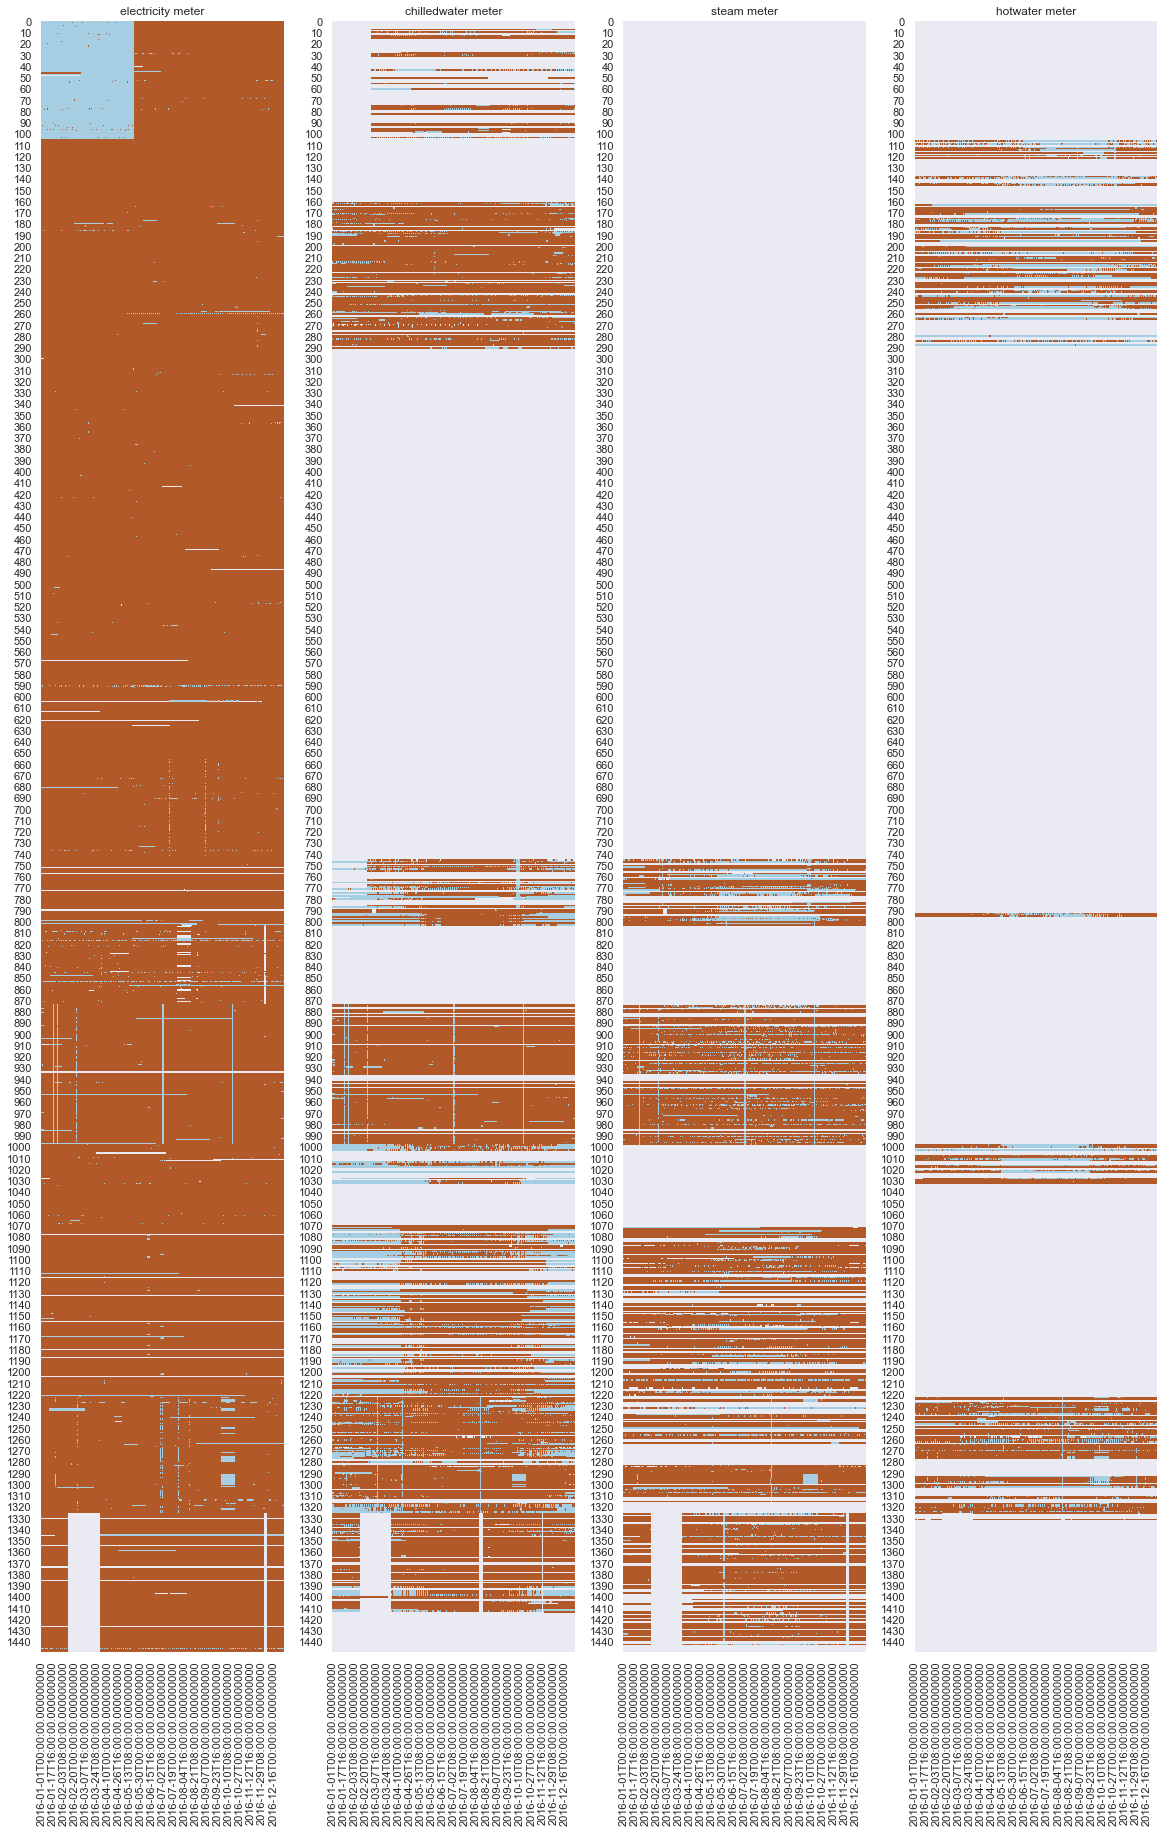

In [8]:
# Visualize missing values and zeroes
# Adapted from: https://www.kaggle.com/hmendonca/clean-weather-data-eda#Check-the-meter-averages-per-weekday

meter_types = ['electricity', 'chilledwater', 'steam', 'hotwater']
fig, ax = plt.subplots(1, 4, figsize=(20, 30))

for m in range(4):
    
    df = meter[meter.meter == m]
    mmap = df.pivot(index='building_id', columns='timestamp', values='meter_reading')
    mmap = mmap.reindex(sorted(meter.building_id.unique()))
    mmap = np.sign(mmap)
    
    sns.heatmap(mmap, cmap='Paired', ax=ax[m], cbar=False)
    ax[m].set_title(f'{meter_types[m]} meter')
    ax[m].set_ylabel(None)
    ax[m].set_xlabel(None)

In [9]:
# Drop observations with a meter reading of 0
meter.drop(index=meter[meter.meter_reading <= 0].index, inplace=True)
meter.shape

(18264895, 11)

In [ ]:
# Check zeroes again
fig, ax = plt.subplots(1, 4, figsize=(20, 30))
for m in range(4):
    df = meter[meter.meter == m]
    mmap = df.pivot(index='building_id', columns='timestamp', values='meter_reading')
    mmap = mmap.reindex(sorted(meter.building_id.unique()))
    mmap = np.sign(mmap)
    sns.heatmap(mmap, cmap='Paired', ax=ax[m], cbar=False)
    ax[m].set_title(f'{meter_types[m]} meter')
    ax[m].set_ylabel(None)
    ax[m].set_xlabel(None)

### Buildings built in 2016 and 2017

In [ ]:
# # Inspect buildings with a year_built of 2016 and 2017
# yb1617 = building[building.year_built.isin([2016, 2017])]
# yb1617

In [ ]:
# # Count meter readings in these buildings
# bldgs = yb1617.building_id.tolist()
# mr1617 = [meter[meter.building_id == bldg].shape[0] for bldg in bldgs]

# # Add the total
# bldgs.append('Total')
# mr1617.append(sum(mr1617))

# # Convert to dataframe
# pd.DataFrame(zip(bldgs, mr1617), columns=['building', 'meter_reading_count'])

In [ ]:
# # Remove 2016 and 2017 buildings
# meter = pd.merge(meter, building[['building_id', 'year_built']], on='building_id', how='left')
# meter = meter[~meter.year_built.isin([2016, 2017])]
# print(meter.shape)
# meter.head(2)

In [ ]:
del meter_types, fig, ax, m, df, mmap
# del yb1617, bldgs, mr1617
gc.collect()

### Reindex weather data

In [ ]:
# Reindex weather data to include every hour of every day in 2016
weather = udf.reidx_site_time(weather, t_start='1/1/2016 00:00:00', t_end='12/31/2016 23:00:00')
weather.info()

### Weather interpolation for missing values

In [ ]:
# Missing values
wthr_missing = pd.DataFrame(zip(weather.isnull().sum(), np.round(weather.isnull().mean() * 100, 2)), 
                            index=weather.columns, columns=['missing', 'pct_missing'])
wthr_missing

In [ ]:
# Missing values by site
udf.missing_vals_by_site(weather, pct=True)

In [ ]:
# Drop cloud_coverage and precip_depth_1_hr
weather.drop(['cloud_coverage', 'precip_depth_1_hr'], axis=1, inplace=True)
weather.head(2)

In [ ]:
# Time interval to plot
start, end = datetime.date(2016, 1, 1), datetime.date(2016, 1, 31)

# Site 15 air temperature and wind speed
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, ax=ax, xticks=[], xlabel='Day', 
                                                           title='January 2016 Weather')
plt.show()

In [ ]:
# Use linear interpolation for variables with min/max constraints and cubic interpolation for the rest
lin_cols = ['wind_direction', 'wind_speed']
cub_cols = ['air_temperature', 'dew_temperature', 'sea_level_pressure']

# Fill missing values by site
weather = udf.fill_missing(weather, [], lin_cols, cub_cols)
udf.missing_vals_by_site(weather, pct=True)

In [ ]:
# Site 15 air temperature and wind speed
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, ax=ax, xticks=[], xlabel='Day', 
                                                           title='January 2016 Weather')
plt.show()

### Missing site 5 sea level pressure values

In [ ]:
# Extract the 3 European sites
w1 = udf.get_site(weather, 1, time_idx=True)
w5 = udf.get_site(weather, 5, time_idx=True)
w12 = udf.get_site(weather, 12, time_idx=True)

# Air temperature in January from all 3
w1.loc[start:end, 'air_temperature'].plot(label='Site 1')
w5.loc[start:end, 'air_temperature'].plot(label='Site 5')
w12.loc[start:end, 'air_temperature'].plot(label='Site 12')
plt.title('January 2016 Temperature of European Sites')
plt.ylabel('Air temperature')
plt.xlabel('Day')
plt.legend()
plt.show()

In [ ]:
# Sea-level pressure in January from sites 
w1.loc[start:end, 'sea_level_pressure'].plot(label='Site 1')
w12.loc[start:end, 'sea_level_pressure'].plot(label='Site 12')
plt.title('January 2016 Sea-level Pressure of Sites 1 and 12')
plt.ylabel('Sea level pressure')
plt.xlabel('Day')
plt.legend()
plt.show()

In [ ]:
# Indices of sites 1 and 5
i1 = weather[weather.site_id == 1].index 
i5 = weather[weather.site_id == 5].index

# Copy site 1's sea_level_pressure data over to site 5
weather.loc[i5, 'sea_level_pressure'] = weather.loc[i1, 'sea_level_pressure'].values
weather[weather.site_id == 5].head(2)

In [ ]:
# Inspect missing values again
weather.isnull().sum()

### Recast wind direction to integer type

In [ ]:
# Convert wind_direction to unsigned integers
weather['wind_direction'] = weather.wind_direction.astype('uint16')
weather.info()

In [ ]:
del wthr_missing, start, end, w15, lin_cols, cub_cols, w1, w5, w12, i1, i5
gc.collect()

### Missing values in building data

In [ ]:
# Missing values
bldg_missing = pd.DataFrame(zip(building.isnull().sum(), round(building.isnull().mean() * 100, 2)), 
                            index=building.columns, columns=['missing', 'pct_missing'])
bldg_missing

In [ ]:
# Check feature correlation
building.corr()

In [ ]:
# Drop floor_count
building.drop('floor_count', axis=1, inplace=True)

# Add missing indicator for year_built
building['missing_year'] = building.year_built.isnull().astype('uint8')
building.head(2)

In [ ]:
# Number of buildings missing year by site
yr_missing_by_site = pd.DataFrame()
yr_missing_by_site['n_values'] = building.groupby('site_id').building_id.count().values
yr_missing_by_site['n_missing'] = building.groupby('site_id').missing_year.sum().values
yr_missing_by_site['pct_missing'] = (yr_missing_by_site.n_missing / yr_missing_by_site.n_values).round(4) * 100
yr_missing_by_site

In [ ]:
# Sites with at least 1 recorded year_built value
sites_with_yr_vals = yr_missing_by_site[yr_missing_by_site.pct_missing < 100].index
i = 0

# Plot these sites
fig, ax = plt.subplots(2, 4, figsize=(16, 6))
fig.subplots_adjust(hspace=0.4)
for a in ax:
    for b in range(4):
        bldg = building[building.site_id == sites_with_yr_vals[i]]
        a[b].hist(bldg.year_built)
        a[b].set_title('Site {} ({} buildings recorded)'.format(sites_with_yr_vals[i], bldg.shape[0]))
        i += 1

In [ ]:
# Fill missing year_built values with the building's site's median year_built value
building['year_built'] = building.groupby('site_id').year_built.transform(lambda y: y.fillna(y.median()))

# Check percent missing year_built again
(yr_missing_by_site['n_values'] - building.groupby('site_id').year_built.count()) * 100 / \
yr_missing_by_site['n_values']

In [ ]:
# Fill the other sites with primary_use medians
building['year_built'] = building.groupby('primary_use').year_built.transform(lambda y: y.fillna(y.median()))

# Fill the rest with the building's site's median
building['year_built'] = building.groupby('site_id').year_built.transform(lambda y: y.fillna(y.median())).astype(int)

# Check null count again
building.isnull().sum()

In [ ]:
# Distribution of year-built values
building.year_built.plot.hist(bins=40, title='Distribution of year_built')
plt.show()

In [ ]:
del bldg_missing, yr_missing_by_site, sites_with_yr_vals, i, fig, ax, a, b, bldg
gc.collect()

### Merge dataframes

In [ ]:
# # Merge meter and building dataframes
# metr_bldg = pd.merge(meter.drop('site_id', axis=1), building, on='building_id', how='left')
# metr_bldg.head(2)

In [ ]:
# # Add weather to the merge
# train = pd.merge(metr_bldg, weather, on=['site_id', 'timestamp'], how='left')
# train.head(2)

In [ ]:
# # Reorder columns
# cols = ['site_id', 'building_id', 'meter', 'meter_type', 'timestamp', 'meter_reading', 
#         'air_temperature', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed', 
#         'primary_use', 'square_feet', 'year_built', 'missing_year', 
#         'dayofyear', 'month', 'day', 'hour', 'dayofweek']
# train = train[cols]
# train.info()

In [ ]:
# del cols
# gc.collect()

### Save dataframes

In [ ]:
# Create new subdirectory in data directory
output_path = '../data/from_prep/'
udf.mkdir(output_path)

In [ ]:
# Save meter data
meter.to_pickle(output_path + 'meter.pkl')
pd.read_pickle(output_path + 'meter.pkl').head(2)

In [ ]:
# Save weather data
weather.to_pickle(output_path + 'weather.pkl')
pd.read_pickle(output_path + 'weather.pkl').head(2)

In [ ]:
# Save building data
building.to_pickle(output_path + 'building.pkl')
pd.read_pickle(output_path + 'building.pkl').head(2)

In [ ]:
# # Save combined data
# train.to_pickle(output_path + 'train.pkl')
# pd.read_pickle(output_path + 'train.pkl').head(2)